In [17]:
from google.colab import drive
drive.mount('/content/drive/')

import warnings
warnings.filterwarnings("ignore")

ModuleNotFoundError: No module named 'google.colab'

In [2]:
!pip install stellargraph

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [6]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

import networkx as nx
from networkx.algorithms import bipartite

from stellargraph.data import UniformRandomMetaPathWalk
from stellargraph import StellarGraph


In [7]:
#Read Datasets

path = "/content/drive/MyDrive/LAB4311/DATA"

#train_s1 = pd.read_csv(path+'/s1/train.tsv', sep='\t')
train_5core_s1 = pd.read_csv(path+'/s1/train_5core.tsv', sep='\t')
#valid_qrel_s1 = pd.read_csv(path+'/s1/valid_qrel.tsv', sep='\t')
#valid_run_s1 = pd.read_csv(path+'/s1/valid_run.tsv', sep='\t', header=None)
#valid_run_s1.columns = ['userId','itemId']

In [8]:
def load_df(data_path):
    df = pd.read_csv(data_path, sep='\t')
    df = df[['userId','itemId','rating']]
    print(len(df))
    return df

In [9]:
df = load_df('/content/drive/MyDrive/LAB4311/DATA/s1/train_5core.tsv')

77173


In [10]:
df

,userId,itemId,rating
0,s1U1109116,P1011533,1.0
1,s1U1108937,P1005973,1.0
2,s1U1114175,P1023744,1.0
3,s1U1031014,P1006341,1.0
4,s1U1082675,P1006604,1.0
...,...,...,...
77168,s1U1040528,P1034679,1.0
77169,s1U1033729,P1034814,1.0
77170,s1U1033729,P1034665,1.0
77171,s1U1033729,P1035217,1.0


In [11]:
train_5core_s1.shape


(77173, 3)

In [12]:
#Create Bipartite Graph

G_source = nx.Graph()
G_source.add_nodes_from(train_5core_s1["userId"].unique(),bipartite=0,label="userId")
G_source.add_nodes_from(train_5core_s1["itemId"].unique(),bipartite=1,label="itemId")
G_source.add_weighted_edges_from([(uId, iId,rating) for (uId, iId, rating) in train_5core_s1[['userId', 'itemId', 'rating']].to_numpy()])

## Information About Bidirected Graph

In [14]:
nx.info(G_source)

'Graph with 16228 nodes and 76965 edges'

In [15]:
nx.is_connected(G_source)
bottom_nodes, top_nodes = bipartite.sets(G_source)

In [16]:
print(f'Number of user nodes: {len(bottom_nodes)} , Number of item nodes: {len(top_nodes)}')

Number of user nodes: 6466 , Number of item nodes: 9762


## Create r-ego Network

In [17]:
def create_ego_network(G,r):
  bottom_nodes, top_nodes = bipartite.sets(G)
  hub_ego_list = [nx.ego_graph(G,hub,r,center=True) for hub in bottom_nodes]
  return hub_ego_list

In [18]:
G_u = create_ego_network(G_source,2) #The r-ego network of vertex u, denoted as Gu, is a sub-graph.

In [20]:
print(nx.info(G_u[0]))

Graph with 90 nodes and 89 edges


#An example

In [19]:
nx.is_bipartite(G_u[0]) , nx.is_connected(G_u[0])

(True, True)

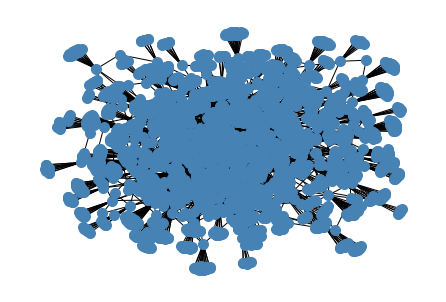

In [21]:
hub_node = 's1U1127262'
hub_ego = nx.ego_graph(G_source, hub_node ,radius=3,center=True)

# showing the ego network
nx.draw(hub_ego, node_color="steelblue", 
        node_size = 100, with_labels = False)

plt.show()

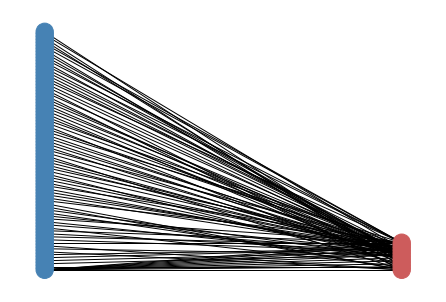

In [22]:
color_map = []
for node in G_u[0].nodes:
  if str(node).startswith('s'):
    color_map.append('steelblue')
  else:
    color_map.append('indianred')

user, item = bipartite.sets(G_u[0])
pos = dict()
pos.update( (n, (1, i)) for i, n in enumerate(user) ) # put nodes from user
pos.update( (n, (2, i)) for i, n in enumerate(item) ) # put nodes from item
nx.draw(G_u[0], pos=pos, node_color=color_map)
plt.show()

# **Data Augmentation**
## **Random Walk Sampling**

In [23]:
def convert_stellar_graph(nx_graph_list):
    S_graph_list = [StellarGraph.from_networkx(g, edge_type_default = "rating", edge_weight_attr = "weight") for g in nx_graph_list]
    return S_graph_list

In [24]:
S_graph_list = convert_stellar_graph(G_u)

In [25]:
len(S_graph_list)

6466

In [26]:
print(S_graph_list[0].info())

StellarGraph: Undirected multigraph
 Nodes: 90, Edges: 89

 Node types:
  userId: [80]
    Features: none
    Edge types: userId-rating->itemId
  itemId: [10]
    Features: none
    Edge types: itemId-rating->userId

 Edge types:
    itemId-rating->userId: [89]
        Weights: all 1 (default)
        Features: none


In [27]:
def graph_randow_walk(g,n,length,metapaths):
  #Create random walker
  rw = UniformRandomMetaPathWalk(g)

  walks = rw.run(nodes=list(g.nodes()),#root nodes
               length=length, #max length of a random walk
               n=n, #number of random walks per root node
               metapaths=metapaths,
               )
  return walks

In [28]:
#Specify the metapath schemas as a list of lists of node types
metapaths = [["userId","itemId","userId"]]

random_walks = [graph_randow_walk(g,2,20,metapaths) for g in S_graph_list]


In [29]:
import random
rand_idx = random.randrange(len(random_walks))
g_q = random_walks[0][0]
g_k = random_walks[0][1]
g_1 = random_walks[rand_idx][0]
g_2 = random_walks[rand_idx][1]

In [30]:
g_q

['s1U1033949',
 'P1008751',
 's1U1048185',
 'P1008751',
 's1U1015236',
 'P1008751',
 's1U1028972',
 'P1008751',
 's1U1060612',
 'P1008751',
 's1U1033949',
 'P1002950',
 's1U1015350',
 'P1002950',
 's1U1033949',
 'P1016090',
 's1U1057805',
 'P1016090',
 's1U1077852',
 'P1016090']

In [31]:
g_k

['s1U1033949',
 'P1001066',
 's1U1033949',
 'P1018532',
 's1U1052784',
 'P1018532',
 's1U1026755',
 'P1018532',
 's1U1057845',
 'P1018532',
 's1U1026755',
 'P1018532',
 's1U1052499',
 'P1018532',
 's1U1088526',
 'P1018532',
 's1U1052784',
 'P1018532',
 's1U1033949',
 'P1001066']

In [32]:
g_1

['s1U1088870',
 'P1004622',
 's1U1136944',
 'P1004622',
 's1U1040357',
 'P1004114',
 's1U1131186',
 'P1004114',
 's1U1023905',
 'P1004114',
 's1U1040357',
 'P1015842',
 's1U1098590',
 'P1015842',
 's1U1015464',
 'P1015842',
 's1U1098590',
 'P1015842',
 's1U1048195',
 'P1015842']

In [33]:
g_2

['s1U1088870',
 'P1004622',
 's1U1028726',
 'P1004622',
 's1U1120895',
 'P1004622',
 's1U1061433',
 'P1004622',
 's1U1040357',
 'P1015842',
 's1U1015464',
 'P1015842',
 's1U1040357',
 'P1013280',
 's1U1103268',
 'P1013280',
 's1U1037097',
 'P1013280',
 's1U1005437',
 'P1013280']